---
title: "Judging Wine Prices: Selecting a Model (Part 2)"
description: "Using both context (SBERT) and keywords (TF-IDF) with XGBoost"
author:
  - name: Stephen Ro
    url: https://royourboat.github.io/
date: 07-11-2023
categories: [Python, JSON, BERT, NLP, machine-learning, sklearn] # self-defined categories
citation: 
  url: https://royourboat.github.io/posts/2023-07-11-price-sentiment-2/ 
image: nyt.jpg
draft: false # setting this to `true` will prevent your post from appearing on your listing page until you're ready!
footnotes-hover: true
format: 
  html:
    code-fold: true
    code-overflow: wrap
    toc: true
    code-block-background: true
    code-block-border-left: "#31BAE9"
number-sections: false
highlight-style: github

markdown:
  wrap: 72
---

# Reminder

This is part two of a series where I train a machine learning model on price sentiment. 

In part two, I'll go over:

- Preparing the wine review data
- Grid searching machine learning model candidates 
- Selecting the best performing model

Check out [part one](../2023-07-10-price-sentiment/) to learn about the training data.

# Feature Engineering

## Training Data

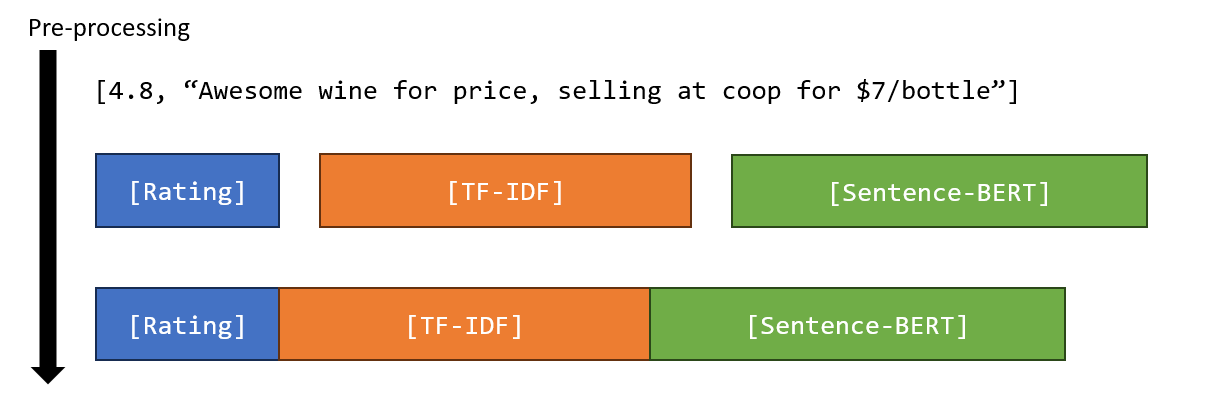

#### 1. Read and re-label data

In [1]:
#| echo: false
dirIn = "D:\\vivino_data\\survey_results\\"
filename = dirIn + "all_labelled_surveys.csv"

In [2]:
#| code-summary: "Code: Read and re-label 'Neutral' as 'Negative'"
import pandas as pd

# Read and re-label data set
rewriteDict = {
    'Positive': 'Positive',
    'Neutral': 'Negative',
    'Negative': 'Negative',
    "Don't know": "Don't know"
}
df = pd.read_csv(filename, encoding='utf-8-sig')
df = df[['reviews','sentiment', 'rating']]
df['sentiment'] = df['sentiment'].apply(lambda x: rewriteDict[x]) # Re-label 'Neutral' as 'Negative

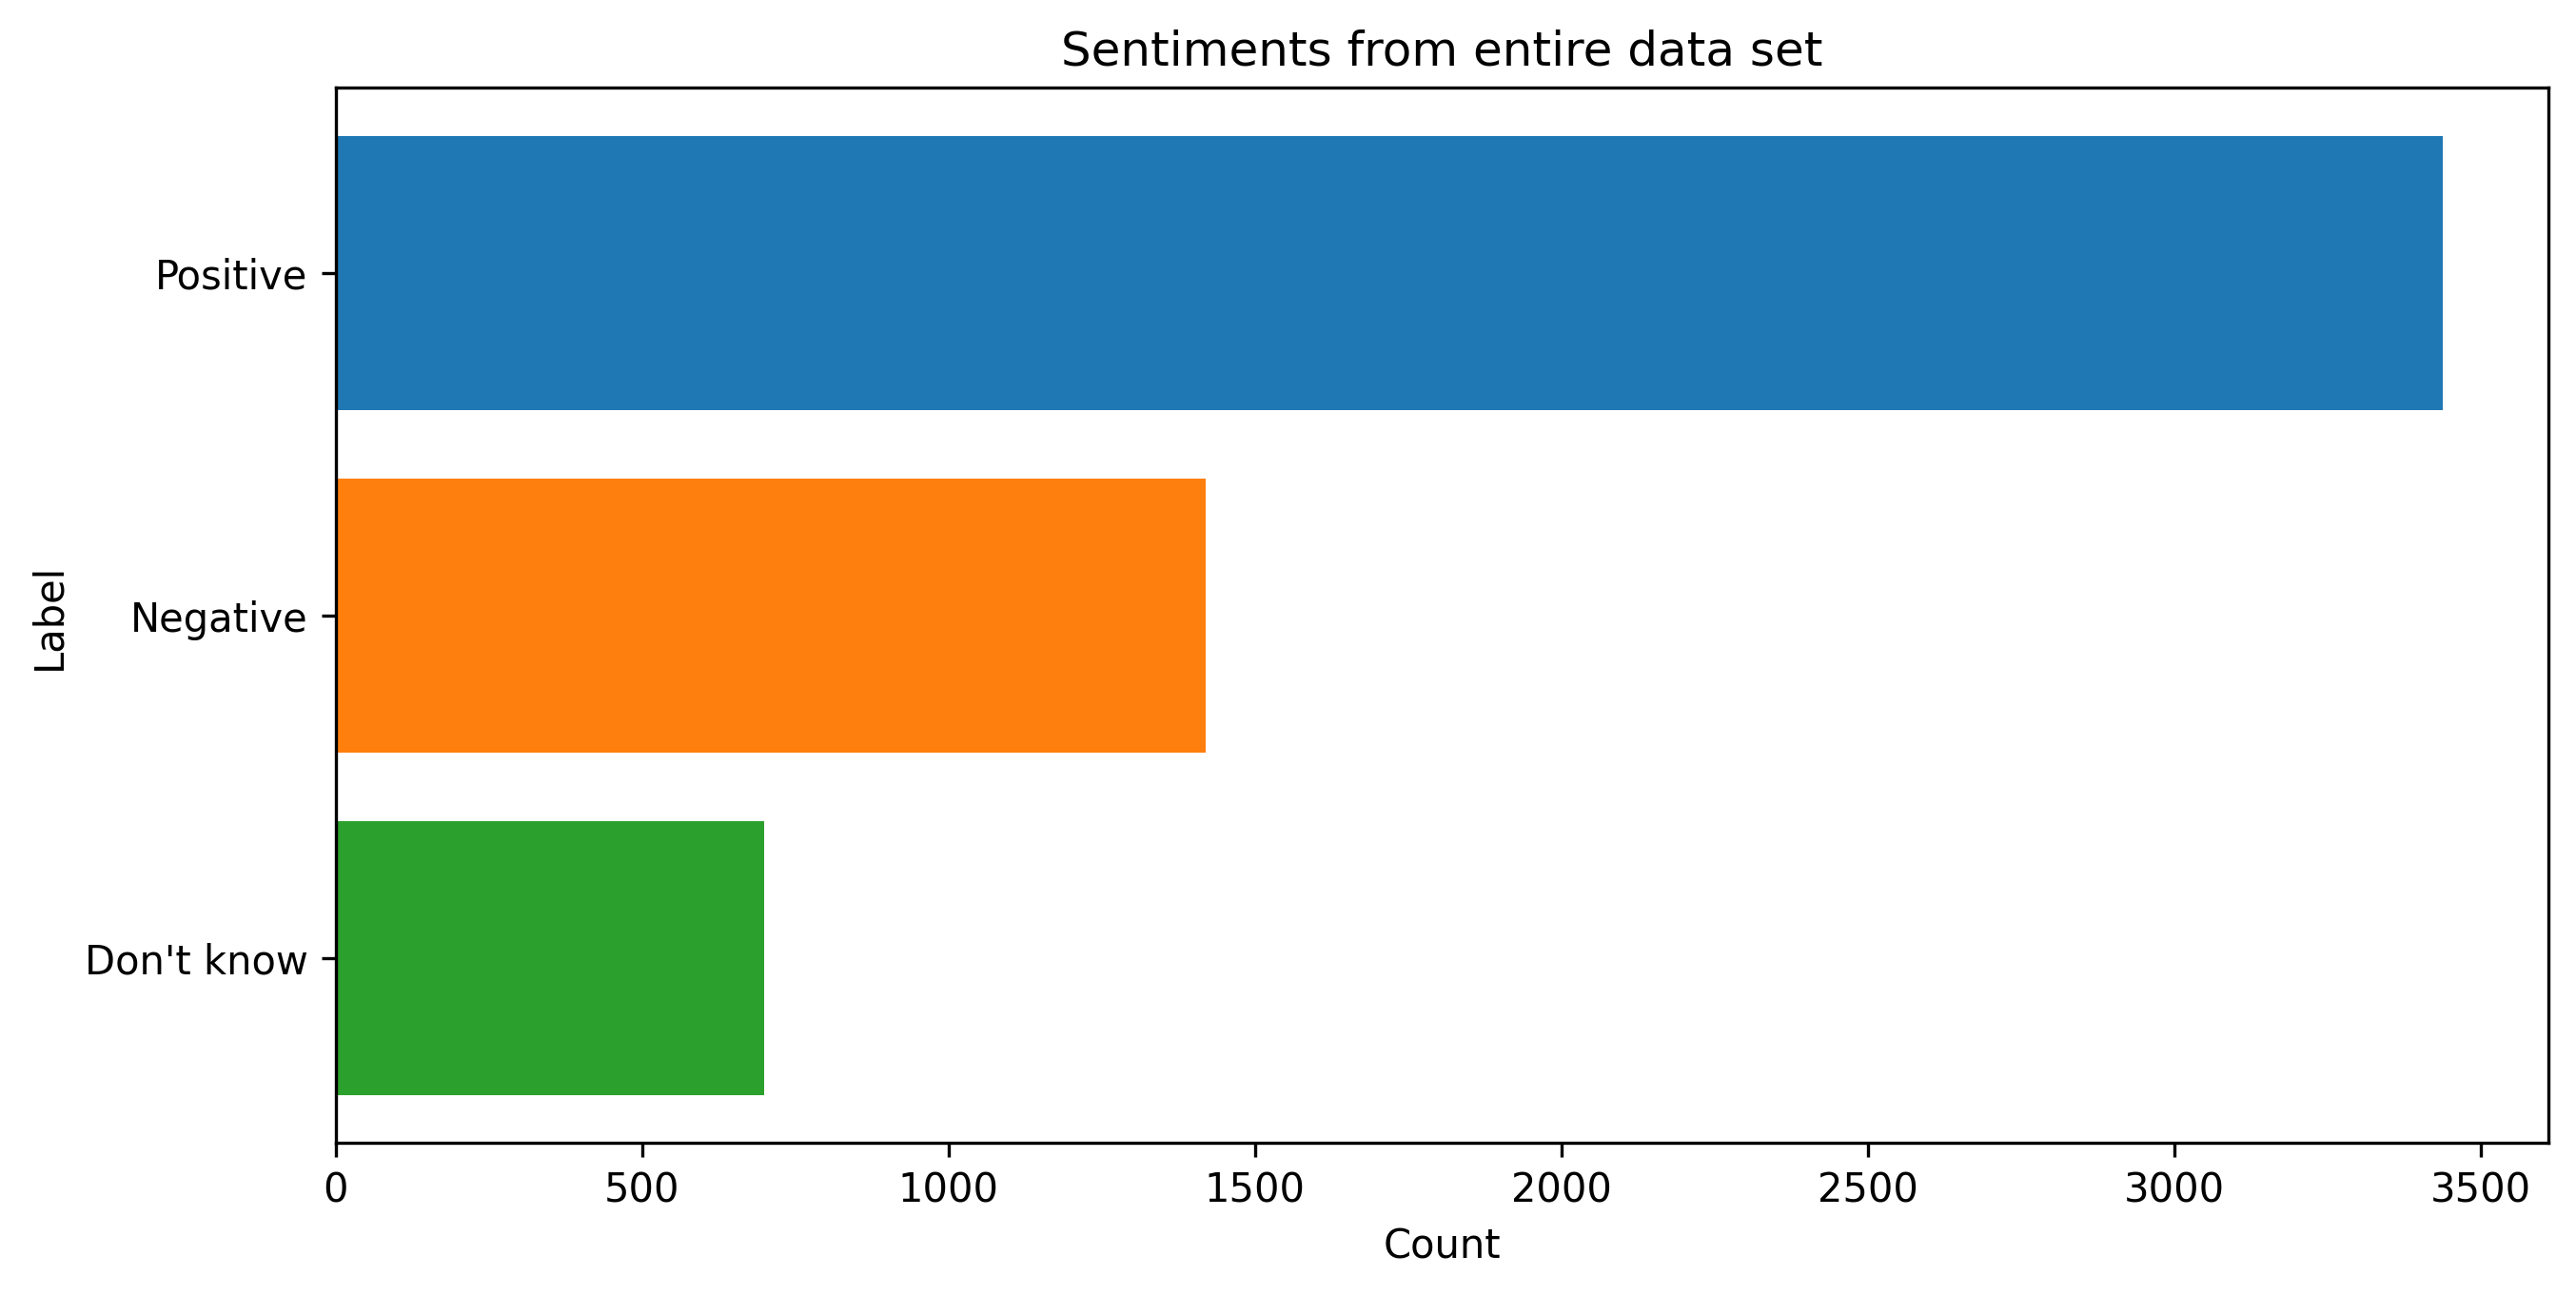

In [13]:
#| echo: false
import matplotlib.pyplot as plt
import numpy as np

sentiment_count = df['sentiment'].value_counts()

# Plot data set counts
fig, ax = plt.subplots()
fig.set_figwidth(10,1)
fig.set_dpi(300)
labels = ['Positive', 'Negative', "Don't know"]
x = [sentiment_count[label] for label in labels]
y = np.arange(len(x))*0.1
for i in range(len(x)):
  ax.barh(y[i], x[i], height=0.08)
ax.set_yticks(y, labels=labels)
ax.set_xlabel('Count')
ax.set_ylabel('Label')
ax.set_title('Sentiments from entire data set')
ax.invert_yaxis()

#### 2. Rescale star-ratings since many models require feature scaling

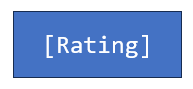{fig-align="left"}

In [14]:
#| code-fold: false
df['unit_rating'] = (df['rating'] - 1) / 4  # Normalize 5-star rating

#### 3. Filter longer reviews (1%) from training

Here is a log-histogram of word frequency per review that I made in this [post](../2023-07-06-vivino-part1/). The number of words per review cannot exceed a threshold since (a) the character limit per review is 520, and (b) the average characters per word is 4.79 (or 5.79 if you include a white space). This threshold is 520 / 5.79 ~ 90, which is approximately where the knee of the distribution is. 

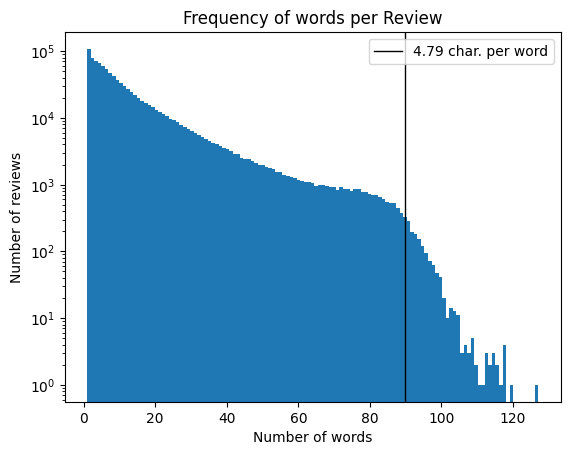

From experiments, I found that filtering out reviews with more than 350 characters (roughly 60 average-length words) improved every model's performance by a few percent. The price-sentiment takes relatively little estate in a review. So, sacrificing 1% of reviews is a small penalty for a 3% model improvement!

In [15]:
#| code-fold: false
df['len'] = df['reviews'].apply(len)
df = df[df['len']<=350]

#### 4. Strip and clean review text

In [16]:
#| code-summary: "Code: Text cleaning functions"
import emoji
import re

def remove_emoji(s):
    # Useful emoji ripper
    return emoji.replace_emoji(s)

def remove_excess_and_newline(s):
    # Removes excessive fullstops (periods)..., !, and newlines.
    s = re.sub(r"\n", ' ', s)
    s = re.sub(r"\.+", '.', s)
    s = re.sub(r"!+", '!', s)
    return s

def filter_characters(s):
    # Only permit the follow characters in reviews. 
    # Mainly deletes unwanted symbols such as: (){}#@^&*
    s = re.sub(r"[^a-zA-Z\d\s'’$\.!\-?£€,:éè%/]", '', s)
    return s

def filter_only_characters(s):
    # Only permit characters in reviews. 
    s = re.sub(r"[^a-zA-Z\s]", '', s)
    return s

def fix_whitespace_around_punctuation(s):
    # Many reviews have incorrect punc "wine,try", "wine.try", "wine .try"
    s = re.sub(r",", ', ', s)
    s = re.sub(r" ,", ',', s)
    s = re.sub(r" \.", '.', s)
    s = re.sub(r"(?<=[.,!?])(?=[^\s\d])", ' ', s)
    s = re.sub(r"(\s)(?=[.,!])", '', s)
    #s = re.sub(r" !", '!', s)
    return s

def strip_extra_whitespace(s):
    # Strip 2+ whitespaces
    s = re.sub("\s+",' ',s)
    return s

def cleaned_text(s):
    s = remove_emoji(s)
    s = remove_excess_and_newline(s)
    s = filter_characters(s)
    s = fix_whitespace_around_punctuation(s)
    s = strip_extra_whitespace(s)
    return s

In [17]:
#| code-summary: "Code: Clean text'"
#| code-fold: false
df['reviews_clean'] = df['reviews'].apply(cleaned_text)

C:\Users\steph\AppData\Local\Temp\ipykernel_28044\1431066477.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reviews_clean'] = df['reviews'].apply(cleaned_text)


Here are some examples of the cleaned text.

In [19]:
#| echo: false
from IPython.display import Markdown
from tabulate import tabulate
sampleReviews = [
    "Loved !!!! \nPairs great with a 50$ steak lol or alone;)",
    "Super soft mouth feel.. fruit forward.  Not sure it’s worth the $50.00 but could be my pallet..",
    "Heavy cherries on the nose , followed by a blackberry taste and spicy velvety smooth finish! More of a light-medium Cabernet and for the money, under $20......wow!!! Good wine 🍷 anytime!",
    "3.7 ~ 87% ($14.75)\nFrescobaldi 🇮🇹 Rèmole Rosso 2017\nMed bodied, bruised, rustic purple ~ black berries, red cherries, and plums ~ smooth as always ~ spicy, oaky, and dry (4 gs/12.5% abv).\nI had the patience of a Buddhist monk, and let this one stew in my bat cave for THREE years! It didn’t really seem to help 😑",
]

# Remove newlines because Markdown hates them.
sampleReviews = [s.replace('\n', ' ') for s in sampleReviews]
sampleReviews_clean = [cleaned_text(s) for s in sampleReviews]
Markdown(tabulate(
  list(zip(sampleReviews, sampleReviews_clean)), 
  headers=[ "Review", "Pre-processed Review" ]
))

Review                                                                                                                                                                                                                                                                                                                     Pre-processed Review
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Loved !!!!  Pairs great with a 50$ steak lol or alone;)                                                                                                                                                                                                                                                                    Loved! Pairs great with a 50$ steak lol or alone
Super soft mouth feel.. fruit forward.  Not sure it’s worth the $50.00 but could be my pallet..                                                                                                                                                                                                                            Super soft mouth feel. fruit forward. Not sure it’s worth the $50.00 but could be my pallet.
Heavy cherries on the nose , followed by a blackberry taste and spicy velvety smooth finish! More of a light-medium Cabernet and for the money, under $20......wow!!! Good wine 🍷 anytime!                                                                                                                                Heavy cherries on the nose, followed by a blackberry taste and spicy velvety smooth finish! More of a light-medium Cabernet and for the money, under $20. wow! Good wine anytime!
3.7 ~ 87% ($14.75) Frescobaldi 🇮🇹 Rèmole Rosso 2017 Med bodied, bruised, rustic purple ~ black berries, red cherries, and plums ~ smooth as always ~ spicy, oaky, and dry (4 gs/12.5% abv). I had the patience of a Buddhist monk, and let this one stew in my bat cave for THREE years! It didn’t really seem to help 😑  3.7 87% $14.75 Frescobaldi Rèmole Rosso 2017 Med bodied, bruised, rustic purple black berries, red cherries, and plums smooth as always spicy, oaky, and dry 4 gs/12.5% abv. I had the patience of a Buddhist monk, and let this one stew in my bat cave for THREE years! It didn’t really seem to help

#### 5. Word significance: bag of words with TF-IDF vectorizer
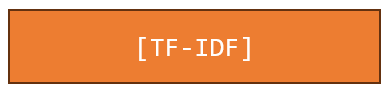

Next, I define a TF-IDF vectorizer.

In [31]:
#| echo: false
import spacy
nlp = spacy.load("en_core_web_sm")
def tokenize_lemma(text):
    text = filter_only_characters(text)
    return [w.lemma_.lower().strip() for w in nlp(text)]

fdir = 'D:/vivino_data/stopwords/'
with open(fdir+'all_stop_words.txt', encoding='utf-8') as file:
    STOP_WORDS = [line.rstrip() for line in file]
STOP_WORDS = set(STOP_WORDS).union({'ll', 've'})
STOP_WORDS = STOP_WORDS.difference({'he', 'his', 'her','hers'})  # Removing a few words that don't lemmatize well
STOP_WORDS = STOP_WORDS - set([''])
STOP_WORDS = set(tokenize_lemma(' '.join(sorted(STOP_WORDS))))
STOP_WORDS = list(STOP_WORDS)

In [32]:
#| code-fold: false
#| error: false
#| warning: false
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
nlp = spacy.load("en_core_web_sm")

def tokenize_lemma(text):
    text = filter_only_characters(text)
    # Lemmatize, lowercase, strip each word token
    return [w.lemma_.lower().strip() for w in nlp(text)]

TFIDFEncoder = TfidfVectorizer(
    ngram_range=(1, 2), 
    # A list of stop words: common, wine nomenclature, dates
    stop_words=STOP_WORDS, 
    tokenizer=tokenize_lemma,
    )

In [236]:
#| echo: false
#| error: false
#| warning: false
#import dill 
#dill.dump(CleanTFIDFTransformer.transformers_[0][1], open('./saves/TFIDFEncoder.dill', 'wb'))

#### 6. Sentence abstraction: transform reviews into sentence embeddings
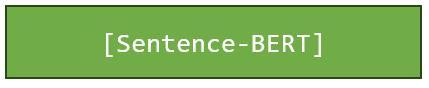

Here is a (scikit-learn) transformer that creates embeddings using the sentence transformer.

In [33]:
#| code-summary: "Code: SBERT Encoder and Column Transformer"
#| code-fold: false
from sentence_transformers import SentenceTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# New sentence embedding model
embeddingModelName = "all-roberta-large-v1"
sentenceModel = SentenceTransformer(embeddingModelName)
outputDim = sentenceModel.get_sentence_embedding_dimension()

# Embedding transformer
class SBERTEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, shift=1, norm=2):
        self.shift = shift
        self.norm = norm
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Create embeddings
        embeddings = sentenceModel.encode(
            list(X.iloc[:,0]), 
            normalize_embeddings = True
            )
        # Rescaling is needed to ensure the elements are between [0,1]
        embeddings = embeddings + self.shift
        embeddings *= self.norm
        return embeddings

#### 7. Combine engineered features
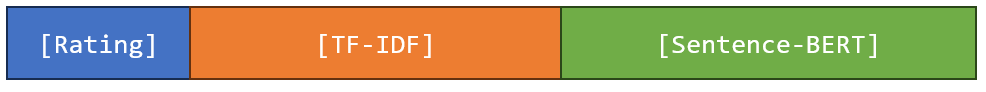

Finally, I create a column transformer that plucks the data columns we want and applies various transformers to them. The outputs of each transformer are merged back together into a large (semi-)sparse matrix.

In [34]:
#| code-fold: false
#| error: false
#| warning: false
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key, make_df = False):
        self.key = key
        self.make_df = make_df

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.make_df:
            return pd.DataFrame(X[self.key])
        return X[self.key]
    
FullSentenceTransformer = ColumnTransformer([
    ('StarRating_transformer', 'passthrough', ['unit_rating']),
    ('TFIDFEncoder_transformer', TFIDFEncoder,  'reviews_clean'),
    ('SentenceEmbeddings_transformer', SBERTEncoder(), ['reviews_clean']),
])

X = FullSentenceTransformer.fit_transform(df)
vocabulary = FullSentenceTransformer.transformers_[1][1].vocabulary_

C:\Users\steph\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\steph\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bro', 'citru', 'roast'] not in stop_words.
  warnings.warn(


In [46]:
#| echo: false
import dill
dill.dump(FullSentenceTransformer, open('./saves/FullSentenceTransformer.dill', 'wb'))

#### 8. Label encode classes

XGBoost and LightGBM require the classes be encoded as integers while the other algorithms do not. Might as well encode everything.

In [36]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
y_encoded = LE.fit_transform(df['sentiment'])
y_encoded_classes = LE.classes_
y_encoded_classes

array(["Don't know", 'Negative', 'Positive'], dtype=object)

In [47]:
#| echo: false
import dill
dill.dump(LE, open('./saves/LabelEncoder.dill', 'wb'))

#### 9. Split data into training and test sets

In [37]:
#| code-summary: "Code: Split data into training and test sets"
#| code-fold: false
from sklearn.model_selection import train_test_split
seed = 42
splitFraction = 0.85
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_encoded, 
                                                    train_size=splitFraction, 
                                                    random_state=seed,
                                                    stratify = y_encoded) 
                                # stratify tries to ensure the split has equal class proprotions
print(f'Training set shape: {X_train.shape}')
print(f'Testing set shape: {X_test.shape}')

Training set shape: (4387, 28436)
Testing set shape: (775, 28436)


#### 10. Create weights for imbalanced data

A common solution to imbalanced data is to under- or oversample until the class frequencies are equal. Under-sampling throws out data and reduces the diversity in majority classes. Oversampling duplicates random samples from the minority classes and increases computation time when machine learning. 

I prefer re-weighting the loss function by the class weights, which works for most models. Its effectively the same as oversampling without the computational expense and random sampling. 

Another really interesting solution is to do sentence augmentation which is oversampling plus a rearrangement of the sentences. This is more applicable considering most sentences are disjoint from others in a short review. This is a work in progress that I will revisit! For now, I stick with class re-weighting. 

In [38]:
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
sample_weight_train = compute_sample_weight(class_weight = 'balanced', y = y_train)
class_name = np.unique(y_train)
class_weight_train = compute_class_weight(class_weight = 'balanced', classes=class_name, y = y_train)
class_weight_train = class_weight_train/np.min(class_weight_train)
class_weight_dict = dict(zip(class_name,class_weight_train))
class_weight_dict

{0: 5.014705882352941, 1: 2.4466367713004487, 2: 1.0}

# Model Fits

There are 5,500 samples of data with thousands of features. The data is imbalanced with a category distribution of 6/2/1. There are several machine learning algorithms that we can try. 

- Dummy Classifier (for comparison)
- Logistic Regression
- (Complement) Naive Bayes
- SVMs (not advised due to large number of features, but we try)
- Random Forests
- XGBoost and LightGBM


In [39]:
#| echo: false
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from mpl_toolkits.axes_grid1 import make_axes_locatable

def GenerateReport(y_pred, y_test, encoder = None):    
    if encoder:
        classes = encoder.classes_
        y_pred = encoder.inverse_transform(y_pred)
        y_test = encoder.inverse_transform(y_test)
    else:
        classes = ["Don't know", 'Negative', 'Positive']

    ws = weightedScore(y_test, y_pred)
    # print(f'Custom weighted score: {ws:.4f}')
    # print( '                       ^^^^^^')
    # print(classification_report(y_test, y_pred, target_names=classes))
    
    # fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    # norm = ["true", None]
    # titles = ['Normalized', 'Count']
    

    # for i in range(2):
    #     axes[i].grid(False)
    #     cm = confusion_matrix(y_test, y_pred, labels=classes, normalize=norm[i])
    #     disp = ConfusionMatrixDisplay(
    #         confusion_matrix=cm, 
    #         display_labels=classes, 
    #     )
    #     disp.plot(ax=axes[i], cmap=plt.cm.Blues, colorbar=False, text_kw={'fontsize':'xx-large'})
    #     disp.ax_.set_title(titles[i],fontdict = {'fontsize': 'xx-large'} )
    #     disp.ax_.xaxis.label.set(fontsize=20)
    #     disp.ax_.yaxis.label.set(fontsize=20)
    #     disp.ax_.tick_params(axis='both', labelsize=15)
    #     disp.ax_.patch.set_edgecolor('black')  
    #     disp.ax_.patch.set_linewidth(1.)  
    #     if norm[i]=="true":
    #         disp.ax_.get_images()[0].set_clim(0, 1)
        
    #     im = disp.ax_.get_images()[0]
    #     divider = make_axes_locatable(axes[i])
    #     cax = divider.append_axes("right", size="5%", pad=0.05)
    #     fig.colorbar(im, cax = cax)  
    # #plt.rcParams.update({'font.size': 18})
    # fig.tight_layout()
    

In [40]:
#| echo: false
import dill 
fdir_model = "./best_fit_models/"

import pandas as pd
from IPython.display import Markdown
from tabulate import tabulate

import numpy as np
import matplotlib.pyplot as plt

dirIn = "D:\\vivino_data\\survey_results\\"
filename = dirIn + "all_labelled_surveys.csv"
df_new = pd.read_csv(filename, encoding='utf-8-sig')

sentiment_count = df_new['sentiment'].value_counts()
sentiment_count /= sum(sentiment_count)
fractionDK = sentiment_count["Don't know"]

from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

def weightedScore(y_true, y_pred, encoder=None):
    if encoder:
        classes = encoder.classes_
        labels = list(range(len(classes)))
    else:
        classes = ["Don't know", 'Negative', 'Positive']
        labels = classes
    
    f1 = f1_score(y_true, y_pred, labels = labels, average=None)
    recall = recall_score(y_true, y_pred, labels = labels, average=None)
    f1Dict = dict(zip(classes, f1))
    recallDict = dict(zip(classes, recall))
    
    scoreVector = np.array([f1Dict['Positive'], f1Dict['Negative'], recallDict["Don't know"]])
    weightsVector = np.array([1, 1, fractionDK])
    score = np.dot(scoreVector, weightsVector) / np.sum(weightsVector)
    
    return score

sentimentScorer = make_scorer(weightedScore, greater_is_better = True, **{'encoder':LE})

In [41]:
#| echo: false
# plotter for roc auc and aucpr 

import dill
import sklearn
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.style import set_palette
import yellowbrick.style as ys
from yellowbrick.style.rcmod import set_aesthetic

set_aesthetic(font='DejaVu Sans')
set_palette('flatui')

def plot_roc_pr(modelFilename):
    
    model = dill.load(open(modelFilename,'rb'))
    if type(model) == sklearn.model_selection._search.GridSearchCV:
        model = model.best_estimator_

    # CV does not set this by default...
    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,4))
    fig.set_dpi(100)

    visualizer_kwargs = {
        'micro': False,
        'macro': False,
        'encoder': LE,
        'iso_f1_curves': True,
        'per_class': True,
    }
    visualizer = ROCAUC(model, ax=axes[0], **visualizer_kwargs)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)  
    visualizer.finalize()  
    
    visualizer = PrecisionRecallCurve(model, ax=axes[1], **visualizer_kwargs)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)  
    visualizer.show()

    plt.show()

In [42]:
#| echo: false

from sklearn.metrics import precision_recall_curve, auc, roc_curve
import dill 

def roc_pr_auc(fname, X_test, y_test):
    model = dill.load(open(fname,'rb'))
    if type(model) == sklearn.model_selection._search.GridSearchCV:
        model = model.best_estimator_
    
    try: 
        y_score = model.predict_proba(X_test)
    except:
        y_score = model.decision_function(X_test)

    pr_auc = []
    roc_auc = []
    for i in model.classes_:
        tmp = []
        precision, recall, _ = precision_recall_curve(y_test, y_score[:,i], pos_label = i, drop_intermediate = True)

        pr_auc.append(auc(recall, precision))
        
        fpr, tpr, _ = roc_curve(y_test, y_score[:,i], pos_label = i, drop_intermediate = True)
        
        roc_auc.append(auc(fpr, tpr))
        
    pr_auc = np.array(pr_auc)
    roc_auc = np.array(roc_auc)
    return roc_auc, pr_auc

# Model Results

The training calculations are appended at the end of this post. Below are the ROC and PR curves for each model.

XGBoost and LightGBM models have the highest ROC AUCs which suggests these are the models to adopt. However, imbalanced datasets inherently have fewer "True Negatives" which limits the dynamic range of the false positive rate (x-axis of ROC). As a result, the ROC AUC is greater or more optimistic than we'd think for imbalanced datasets. 

A more sensitive measure for minority classes is Precision (i.e., your predictive power). If we replace the False Positive Rate in the ROC curve with Precision and invert the X and Y axes, you get the PR curve. 

We can see that the PR AUC is poor for CNB (which is disappointing because it is extremely fast to compute). The DKs are marginally better than random chance.

The PR AUCs suggests the **XGBoost model** is better performing than the LightGBM model by a little bit. (To be fair, I did not explore many LGBMs because it is slower to compute for smaller datasets and they perform relatively equally well.) 

Here are the AUC results from all our models.

In [183]:
#| echo: false
from IPython.display import Markdown
from tabulate import tabulate

fdir_model = "./best_fit_models/"
modelNames = ['LogisticRegression', 'ComplementNB', 'SVC', 'RFC', 'XGBC', 'LGBM']

fnames = [fdir_model + modelName + '.dill' for modelName in modelNames]

auc_results =[]
for fname in fnames:
    a,b = roc_pr_auc(fname, X_test, y_test)
    row = [f"{v:.3f}" for v in  np.concatenate((a,b)).tolist()]
    auc_results.append(row)
    
modelNamesShort = ['']+['LogReg', 'C. Naive Bayes', 'SVC', 'RFC', '**XGBoost**', 'LightGBM']
subheader = ["Don't know", 'Negative','Positive',"Don't know", 'Negative','Positive']
subheader= [f"**{s}**" for s in subheader]
tbl_score = [subheader] + auc_results
tbl_score = list(zip(*tbl_score))
tbl_score = [modelNamesShort] + tbl_score
tbl_score = list(zip(*tbl_score))

headers = ['Model Name', ' ','ROC AUC', '', '', 'PR AUC', '' ]
Markdown(tabulate(
  tbl_score, 
  headers=headers
))

Model Name                      ROC AUC                                     PR AUC
--------------  --------------  ------------  ------------  --------------  ------------  ------------
                **Don't know**  **Negative**  **Positive**  **Don't know**  **Negative**  **Positive**
LogReg          0.883           0.938         0.919         0.536           0.837         0.951
C. Naive Bayes  0.868           0.937         0.916         0.470           0.850         0.948
SVC             0.839           0.922         0.914         0.489           0.817         0.948
RFC             0.900           0.937         0.923         0.581           0.836         0.953
**XGBoost**     0.900           0.937         0.923         0.581           0.836         0.953
LightGBM        0.900           0.938         0.923         0.575           0.839         0.953

Here are 20 words that the XGBoost classifier found to have the highest significance. In another post, I'll go deeper into which words are the most significant per category.

In [327]:
#| echo: false
#| tbl-colwidths: [25,25,25,25]
#| tbl-cap: "**Top 20 Most Significant Words (XGBoost)**"
from numpy import argsort
from IPython.display import Markdown
from tabulate import tabulate

modelName = "XGBC"
model = dill.load(open(fdir_model+f'{modelName}.dill','rb'))
best_model = model.best_estimator_.steps[0][1]
argsort_features = argsort(best_model.feature_importances_)
argsort_words = argsort_features[(argsort_features>0) & (argsort_features<=len(vocabulary))]
num = 20
halfnum = int(num/2)
arg_top = argsort_words[-num:][::-1]

vocabulary_swap = {v: k for k, v in vocabulary.items()}

top_words = [vocabulary_swap[i-1] for i in arg_top] #minus 1 because shift of star rating.
top_score = [best_model.feature_importances_[i] for i in arg_top]
top_score = [f"{s*1e3:.2f}" for s in top_score]
headers = ['Score', 'Word', 'Score', 'Word' ]
Markdown(tabulate(
  list(zip(top_score[0:halfnum],top_words[0:halfnum],top_score[halfnum:],top_words[halfnum:])), 
  headers=headers
))

  Score  Word          Score  Word
-------  ----------  -------  ---------
   3.61  not            1.59  well than
   3.24  value          1.58  decent
   2.73  great          1.46  not worth
   2.48  but            1.46  not bad
   2.45  delicious      1.44  good but
   2.25  bad            1.33  not great
   1.67  good           1.33  overprice
   1.62  bitter         1.33  pricey
   1.62  good value     1.28  region
   1.59  worth          1.26  yes

Here are some predictions of price sentiment for random reviews. Recall that we grouped the Neutrals with the Negatives. So, our model is a bit cynical. E.g., "Decent" = Neutral --> Negative. 

In [97]:
#| echo: false
#| error: false
#| warning: false

from dotenv import load_dotenv

load_dotenv()
sql_address = os.getenv("MYPSQLADDRESS")

import re
q = """
SELECT review_id, vivino_id as vivid2, review, rating, language, created_at FROM vivino_lcbo
TABLESAMPLE SYSTEM(0.1) limit 10000;
"""
tbl = pd.read_sql(q, sql_address)

tbl['unit_rating'] = (tbl['rating']-1)/4

def get_price(s):
    if not s:
        return None
    
    text_dollarSign_first = re.search(r'\w*\$\d+(?:\.\d+)?\w*', s) # Input: "not bad for $10AUD". Output: $10AUD"

    if text_dollarSign_first:
        text_price = text_dollarSign_first
    else:
        text_dollarSign_last = re.search(r'\w*\d+(?:\.\d+)?\$\w*', s) 
        text_price = text_dollarSign_last

    if not text_price:
        return None

    text_price = text_price.group(0)
    text_price = re.search(r'\d+(?:\.\d+)?', text_price).group(0) # Get float representing price paid.
    text_price = text_price.replace('$','')     # Delete '$' sign
    price = int(math.ceil(float(text_price)))        # Round up to nearest dollar
    return price

def is_price(s):
    if get_price(s):
        return True
    else:
        return False  

tbl['price'] = tbl['review'].apply(lambda x: get_price(x)) 
tbl_price = tbl[(tbl['price'].notna()) & (tbl['language'].apply(lambda x: x.strip())=='en')]
tbl_price['reviews_clean'] = tbl_price['review'].apply(cleaned_text)

import dill
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.base import BaseEstimator, TransformerMixin

nlp = spacy.load("en_core_web_sm")
TFIDFEncoder = dill.load(open('./saves/TFIDFEncoder.dill', 'rb'))

# New sentence embedding model
embeddingModelName = "all-roberta-large-v1"
sentenceModel = SentenceTransformer(embeddingModelName)
outputDim = sentenceModel.get_sentence_embedding_dimension()

# Embedding transformer
class SBERTEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, shift=1, norm=2):
        self.shift = shift
        self.norm = norm
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Create embeddings
        embeddings = sentenceModel.encode(
            list(X.iloc[:,0]), 
            normalize_embeddings = True
            )
        # Rescaling is needed to ensure the elements are between [0,1]
        embeddings = embeddings + self.shift
        embeddings *= self.norm
        return embeddings
    
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key, make_df = False):
        self.key = key
        self.make_df = make_df

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.make_df:
            return pd.DataFrame(X[self.key])
        return X[self.key]
    
FullSentenceTransformer = dill.load(open('./saves/FullSentenceTransformer.dill', 'rb'))

X_sample = FullSentenceTransformer.transform(tbl_price)

model = dill.load(open('./best_fit_models/XGBC_FINAL.dill', 'rb'))
LE = dill.load(open('./saves/LabelEncoder.dill', 'rb'))
y_pred = model.predict(X_sample)
y_sample = LE.inverse_transform(y_pred)


num_cut = 10
tbl_sample = tbl_price.iloc[0:num_cut]
headers = ['Rating', 'Review', 'Predicted Price-Sentiment' ]
table_dump = {'headers': headers, 
              'rating':tbl_sample['rating'], 
              'review': tbl_sample['review'].apply(lambda x: x.replace('\n',' ')),  
              'prediction': y_sample[0:10],
              }
#dill.dump(table_dump, open('./saves/prediction_reviews.dill', 'wb'))

C:\Users\steph\AppData\Local\Temp\ipykernel_28044\1769362879.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbl_price['reviews_clean'] = tbl_price['review'].apply(cleaned_text)
C:\Users\steph\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bro', 'citru', 'roast'] not in stop_words.
  warnings.warn(


In [98]:
#| echo: false
#| tbl-colwidths: [10,65,25]
#| tbl-cap: "**Random sample of reviews with predicted price sentiment (XGBoost)**"
import dill

table_dump = dill.load(open('./saves/prediction_reviews.dill', 'rb'))

headers = table_dump['headers']
rating = table_dump['rating']
review = table_dump['review']
prediction = table_dump['prediction']

Markdown(tabulate(
  list(zip(rating, review, prediction)),
  headers=headers
))

  Rating  Review                                                                                                                                                                                                                                                                                                                                                                             Predicted Price-Sentiment
--------  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  ---------------------------
     4    Bought for $20. Great for that price. Def not a 4star at 90 though. Needs to breathe.                                                                                                                                                                                                                                                                                              Positive
     4.1  Dry, kind of mild but also rich and warm (jammy) not funky like I would like. blackberry red fruit fig $17 at The Capital Grille in Chicago                                                                                                                                                                                                                                        Don't know
     4.5  Very light and fruity, refreshing and a fantastic value under $15. My go to bubbly                                                                                                                                                                                                                                                                                                 Positive
     3.5  A really interesting wine full of rich fruit that I’ll have to get back to at some point. A variety of grapes in this blend yield a multi flavored and full bodied blend with oh yes, just a hint of chocolate. Seems like this will age and get even more interesting. Balked at the $28 price tag (have seen it for $25) but it is unique enough to lure me back at some point.  Positive
     3    Crisp, good value at 36$                                                                                                                                                                                                                                                                                                                                                           Positive
     3    Not bad, purchased at Sigel’s for $12.99 but found on sale at Target for $9.99                                                                                                                                                                                                                                                                                                     Negative
     3.5  I enjoy this Italian, Tuscan Chianti wine. Range of prices from $25-30 in Calgary. I like the boldness and body. Very dry. Earth + fruit flavours. Leather, dried figs flavours. Medium tannins and body. I used to like it better than I do now.                                                                                                                                  Don't know
     3.5  Very well done. Medium color, body and taste. Dry, light, not too fruity with typical earthy, leathery Malbec flavor. Not complex but nice and clean.  I think a good value for $11.  Drink again.                                                                                                                                                                                 Positive
     4    Nice balance...a bit on the fruity side but tastes full body.  Certainly recommend under $20..                                                                                                                                                                                                                                                                                     Positive
     4    Great value! $15.99. It's a pinotage that will convince you you might get just like pinotage 😉                                                                                                                                                                                                                                                                                    Positive

Here are the ROC and PR curves for each model. The code to fit these models are further below. 

## 1. Logistic Regression
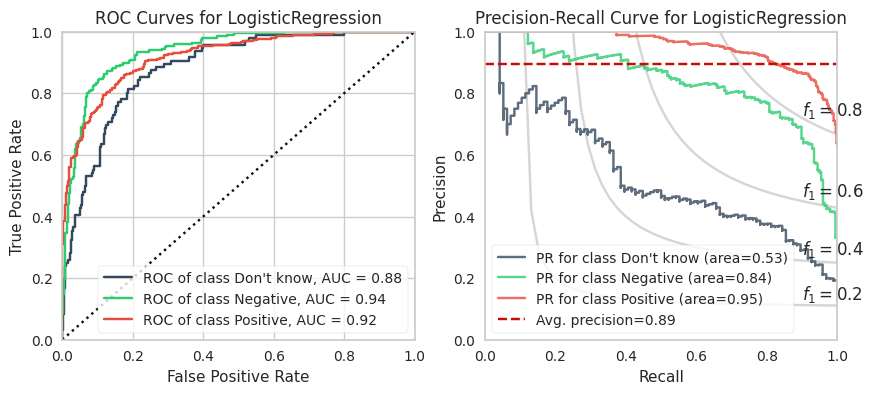

## 2. Complement Naive Bayes
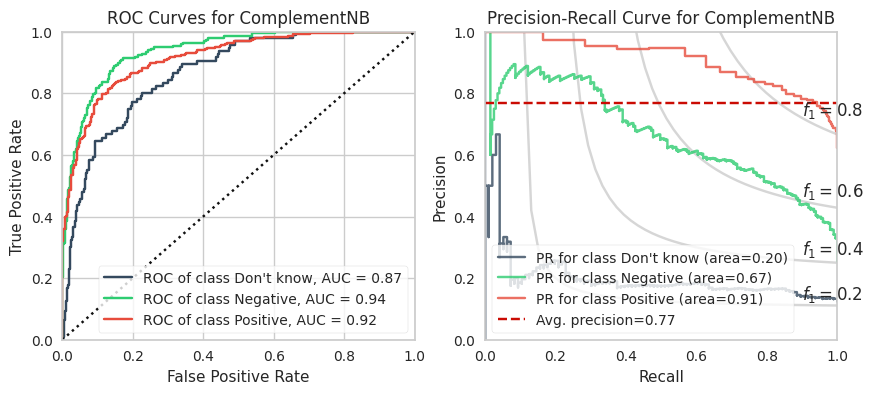

## 3. Support Vector Machine
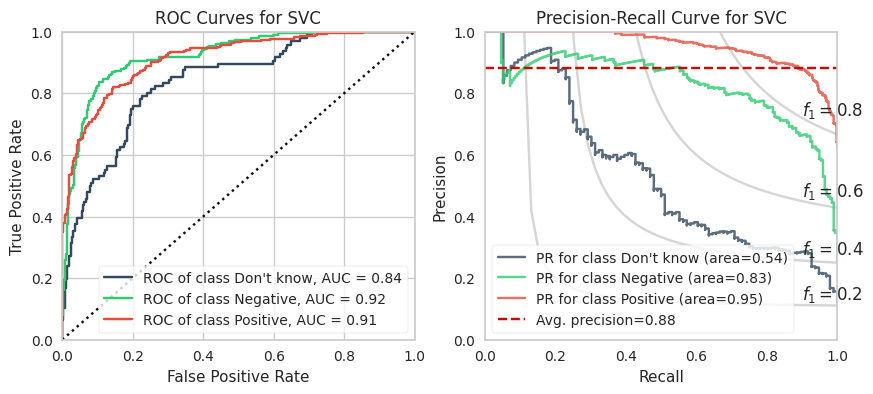

## 4. Random Forest Classifier
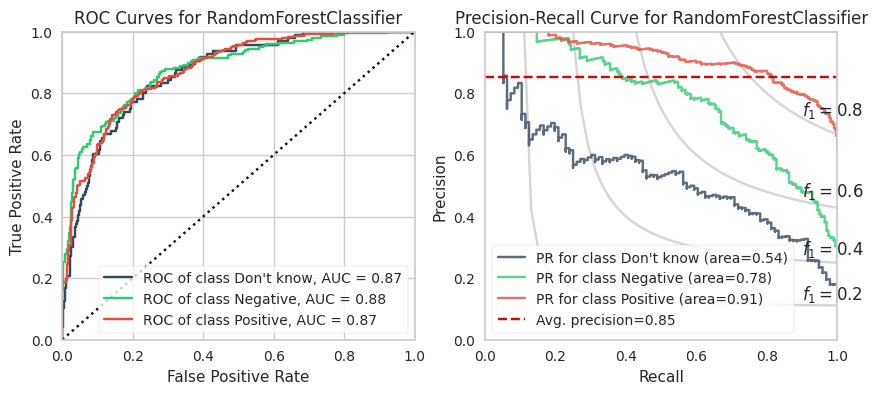

## 5. XGBoost (Winner!)
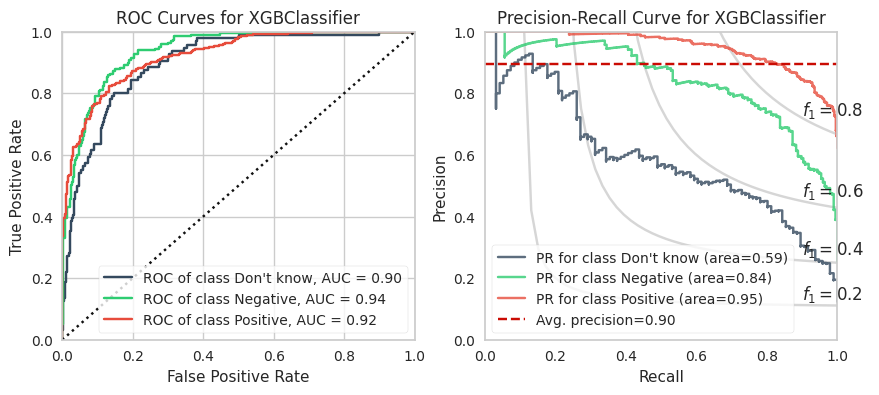

## 6. LightGBM
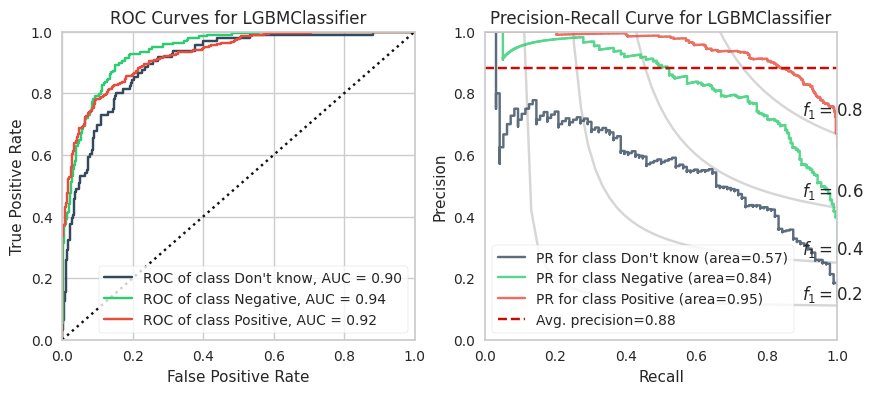

# Model Training Code

## A. Dummy Classifier

The dummy classifier ignores input features. "Stratified" predicts based on the occurrence frequency of classes from the training set. Our custom weighted score is also shown. This is our baseline. 

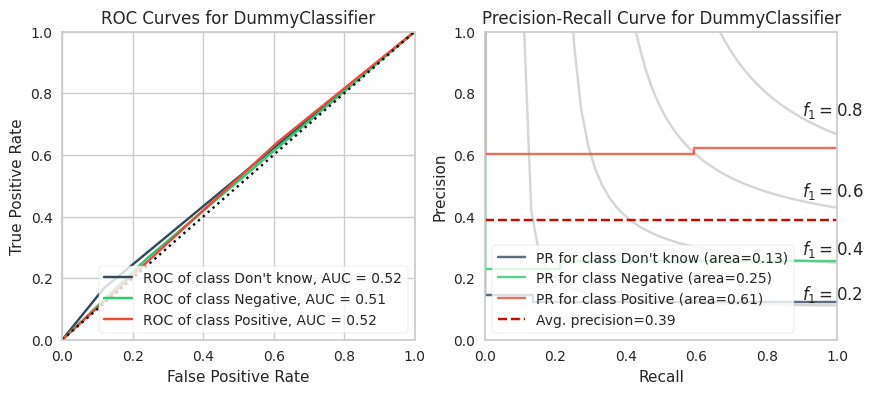

In [182]:
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

modelName = 'DummyClassifier'
pipe = Pipeline([
    (modelName, DummyClassifier(strategy="stratified")), 
])

model = pipe
model.fit(X_train, y_train) 

fname = fdir_model + f'{modelName}.dill'
dill.dump(model, open(fname, 'wb'))

plot_roc_pr(fname)

## B. Logistic Regression

Basic logistic function with L2 regularization. 

In [131]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

modelName = "LogisticRegression"
pipe = Pipeline([
    (modelName, LogisticRegression(max_iter=10000, random_state=42)), 
])

param_grid = {"C": 10**np.arange(-1, 1+0.25, 0.2)}
param_grid = {f"{modelName}__{k}": param_grid[k] for k in param_grid.keys()}

model = GridSearchCV(pipe, 
                     param_grid = param_grid,
                     cv = 5,
                     n_jobs=10,
                     scoring = sentimentScorer,
                     )

kwargs_fit = {modelName+'__sample_weight':sample_weight_train}
model.fit(X_train, y_train, **kwargs_fit) 
print("The best hyperparameter value is: ")
for k,v in model.best_params_.items():
    print(f"{k}: {v}")

fname = fdir_model + f'{modelName}.dill'
dill.dump(model, open(fname, 'wb'))

The best hyperparameter value is: 
LogisticRegression__C: 0.9999999999999994


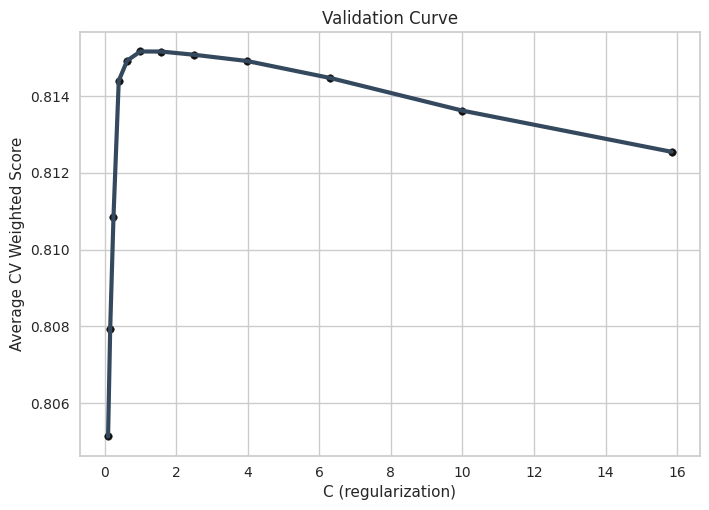

In [132]:
#| echo: false
import dill

model = dill.load(open(fdir_model+'LogisticRegression.dill','rb'))
df_model = pd.DataFrame(model.cv_results_)
x = df_model['params'].apply(lambda x: x['LogisticRegression__C'])
y = df_model['mean_test_score']
plt.plot(x, y, lw=3)
plt.scatter(x, y, s=30, c = 'k')
plt.title('Validation Curve')
plt.xlabel('C (regularization)')
plt.ylabel('Average CV Weighted Score')
#plt.xscale('log')
#plt.legend(prop = { "size": 15 })
plt.show()

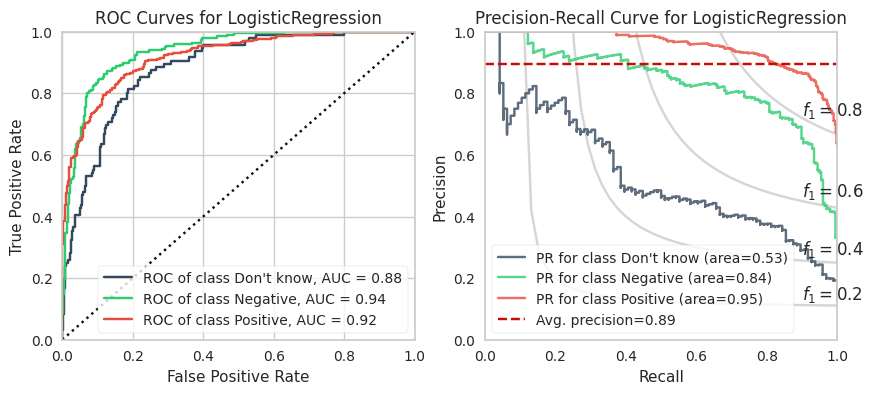

In [133]:
#| echo: false
#| error: false
#| warning: false
modelName = "LogisticRegression"
fname = fdir_model + f'{modelName}.dill'
plot_roc_pr(fname)

In [134]:
#| echo: false
#| tbl-colwidths: [10,40,10,40]
#| tbl-cap: "Highest polarity words: Logistic Regression"
from numpy import argsort

vocabulary_swap = {v: k for k, v in vocabulary.items()}

modelName = "LogisticRegression"
model = dill.load(open(fdir_model+f'{modelName}.dill','rb'))
coef_pos = model.best_estimator_.get_params()[modelName].coef_[LE.transform(['Positive'])[0]] 
coef_neg = model.best_estimator_.get_params()[modelName].coef_[LE.transform(['Negative'])[0]]
coef_dk  = model.best_estimator_.get_params()[modelName].coef_[LE.transform(["Don't know"])[0]]
polarity = coef_pos - coef_neg
indices = argsort(polarity)
tfidf_indices = indices[np.where((indices>0) & (indices<=len(vocabulary)))]

pos_words = []
pos_score = []
num_show = 10
for i in tfidf_indices[-num_show:][::-1]:
    pos_words.append(vocabulary_swap[i])
    pos_score.append(f"{polarity[i]:.2f}")

neg_words = []
neg_score = []
for i in tfidf_indices[:num_show]:
    neg_words.append(vocabulary_swap[i])
    neg_score.append(f"{polarity[i]:.2f}")

#indices = argsort(coef_dk)
#tfidf_indices = indices[np.where((indices>0) & (indices<=len(vocabulary)))]
#print("Don't know Words \n-----")
#for i in tfidf_indices[-50:]:
#    print(f"{polarity[i]:.2f} : {vocabulary_swap[i]}") 

Markdown(tabulate(
  list(zip(pos_score,pos_words,neg_score,neg_words)), 
  headers=['Polarity', 'Positive Words', 'Polarity', 'Negative Words']
))

  Polarity  Positive Words            Polarity  Negative Words
----------  ----------------------  ----------  ----------------
      2.85  good abv                     -4.18  not bargain
      2.56  great absolute               -4.16  decent absolute
      1.94  good valueprice              -3.82  bad acidic
      1.68  value able                   -3.44  not able
      1.35  excellent approachable       -2.79  ok atar
      1.32  pretty great                 -1.75  decent well
      1.32  nice above                   -1.72  bad purchase
      1.32  great versatile              -1.66  not ws
      1.28  worth average                -1.63  like grab
      1.22  pretty acidic                -1.58  not worthy

## C. Complement Naive Bayes

Complement Naive Bayes is apparently the corrected version of MNB when there is imbalanced data.

Note: this is an extremely fast algorithm!

In [156]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import ComplementNB

modelName = "ComplementNB"
pipe = Pipeline([
    (modelName, ComplementNB()), 
])

param_grid = {"alpha": 10**np.arange(-1,1, 0.01)}
param_grid = {f"{modelName}__{k}": param_grid[k] for k in param_grid.keys()}

model = GridSearchCV(pipe, 
                     param_grid = param_grid,
                     cv = 10,
                     n_jobs=10,
                     scoring = sentimentScorer,
                     return_train_score = True,
                     )

kwargs_fit = {modelName+'__sample_weight':sample_weight_train}
model.fit(X_train, y_train, **kwargs_fit) 
print("The best hyperparameters: ")
for k,v in model.best_params_.items():
    print(f"{k}: {v}")

fname = fdir_model + f'{modelName}.dill'
dill.dump(model, open(fname, 'wb'))

The best hyperparameters: 
ComplementNB__alpha: 4.7863009232264


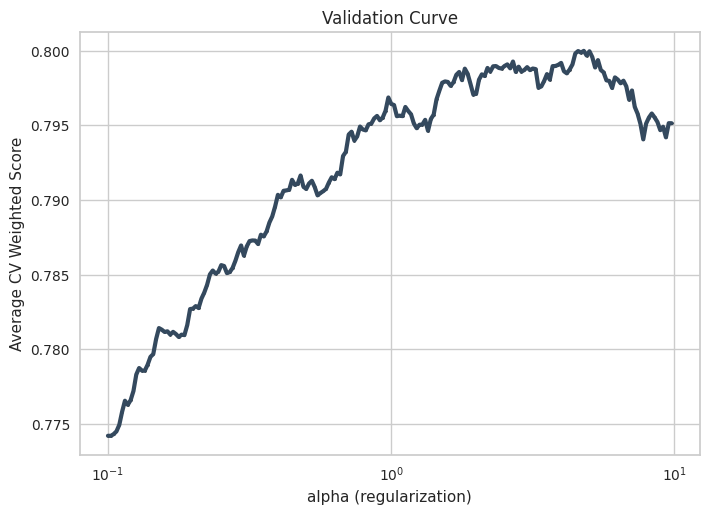

In [157]:
#| echo: false
import dill

model = dill.load(open(fdir_model+'ComplementNB.dill','rb'))
df_model = pd.DataFrame(model.cv_results_)
x = df_model['params'].apply(lambda x: x['ComplementNB__alpha'])
y = df_model['mean_test_score']
y2 = df_model['mean_train_score']
plt.plot(x, y, lw=3)
#plt.plot(x, y2, lw=3, label = 'Train')
plt.scatter(x, y, s=2, c = 'k')
#plt.scatter(x, y2, s=2, c = 'k')
plt.title('Validation Curve')
plt.xlabel('alpha (regularization)')
plt.ylabel('Average CV Weighted Score')
plt.xscale('log')
#plt.legend(prop = { "size": 15 })
plt.show()

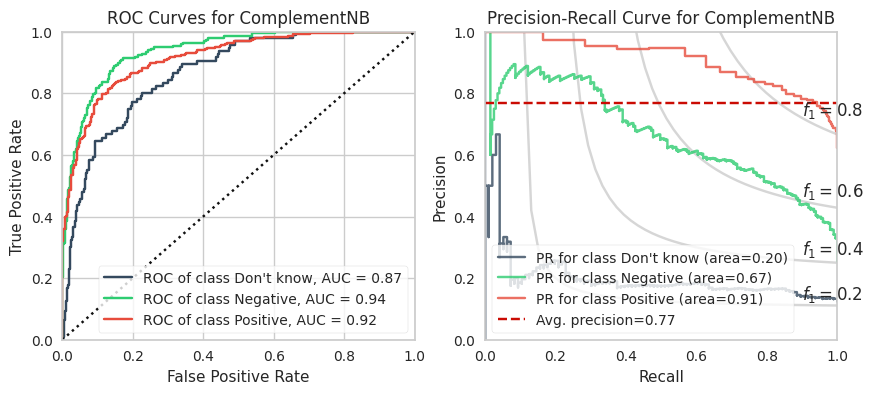

In [159]:
#| echo: false
#| error: false
#| warning: false
modelName = "ComplementNB"
fname = fdir_model + f'{modelName}.dill'
plot_roc_pr(fname)

In [96]:
#| echo: false
#| tbl-colwidths: [10,40,10,40]
#| tbl-cap: "Highest polarity words"
from numpy import argsort

vocabulary_swap = {v: k for k, v in vocabulary.items()}

modelName = "ComplementNB"
model = dill.load(open(fdir_model+f'{modelName}.dill','rb'))
coef_pos = model.best_estimator_.get_params()[modelName].feature_log_prob_[LE.transform(['Positive'])[0]] 
coef_neg = model.best_estimator_.get_params()[modelName].feature_log_prob_[LE.transform(['Negative'])[0]]
coef_dk  = model.best_estimator_.get_params()[modelName].feature_log_prob_[LE.transform(["Don't know"])[0]]
polarity = coef_pos - coef_neg
indices = argsort(polarity)
tfidf_indices = indices[np.where((indices>0) & (indices<=len(vocabulary)))]

pos_words = []
pos_score = []
num_show = 10
for i in tfidf_indices[-num_show:][::-1]:
    pos_words.append(vocabulary_swap[i])
    pos_score.append(f"{polarity[i]:.2f}")

neg_words = []
neg_score = []
for i in tfidf_indices[:num_show]:
    neg_words.append(vocabulary_swap[i])
    neg_score.append(f"{polarity[i]:.2f}")

#indices = argsort(coef_dk)
#tfidf_indices = indices[np.where((indices>0) & (indices<=len(vocabulary)))]
#print("Don't know Words \n-----")
#for i in tfidf_indices[-50:]:
#    print(f"{polarity[i]:.2f} : {vocabulary_swap[i]}") 

Markdown(tabulate(
  list(zip(pos_score,pos_words,neg_score,neg_words)), 
  headers=['Polarity', 'Positive Words', 'Polarity', 'Negative Words']
))

  Polarity  Positive Words            Polarity  Negative Words
----------  ----------------------  ----------  ----------------------
      1.68  great versatile              -1.98  not worthy
      1.44  good valueprice              -1.94  bad acidic
      1.2   value able                   -1.93  not bargain
      1.16  great absolute               -1.41  ok atar
      0.95  great pricepoint             -1.04  would ok
      0.89  steal but                    -0.98  decent absolute
      0.86  excellent vfm                -0.9   overprice artificially
      0.86  excellent approachable       -0.88  not able
      0.75  beat beat                    -0.88  not cad
      0.74  would challenge              -0.86  not grab

## D. Support Vector Machine

SVM attempts to draw boundaries between classes of points using hypersurfaces. Each surface has a margin or "thickness" where points inside the margin become 'support vectors' which, in fact, define the hyper surface. 

The amount of "slack" given to a proposed hypersurface is defined by points located on the wrong side of the hypersurface. The total slack is quantified by the sum of distance (or whatever penalty you define) between these points to the surface. A regularization parameter is used to control the strength of a penalty applied from slack. This is defined as *C* in the following code.

The hypersurface is a hyperplane (i.e., linear) by default. A kernel trick is used to allow malleable surfaces. I will explore a number of kernels which have their own hyperparameters (e.g., dimension of polynomial).

Note: The assumption that the data can be split using a hyperplane is quite strong considering the sparsity of the data and extremely high number of features. SVMs are quite expensive for high numbers of features much like KNNs since the algorithm requires an interpolation of subsets of points (a generally slow process). 

In [136]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np

def linear(X, Y):
    return np.dot(X, Y.T)  

modelName = "SVC"
pipe = Pipeline([
    (modelName, SVC(class_weight='balanced', cache_size=2000, random_state=42)), 
])

C_param = 10**np.arange(0, 2+0.5, 0.25)
param_grid = [
    {'kernel': [linear], 'C': C_param}, # This is much faster than default linear
    {'kernel': ['poly'], 'degree': [2,3], 'C': C_param},
    {'kernel':  ['rbf'], 'C': C_param},
]

param_grid = [
    {f"{modelName}__{k}": grid[k] for k in grid.keys()} for grid in param_grid
]

model = GridSearchCV(pipe, 
                     param_grid = param_grid,
                     cv = 5, #Reduced for time
                     n_jobs=8,
                     scoring = sentimentScorer,
                     )

model.fit(X_train, y_train) 
print("The best hyperparameters: ")
for k,v in model.best_params_.items():
    print(f"{k}: {v}")

fname = fdir_model + f'{modelName}.dill'
dill.dump(model, open(fname, 'wb'))

The best hyperparameters: 
SVC__C: 56.23413251903491
SVC__kernel: rbf


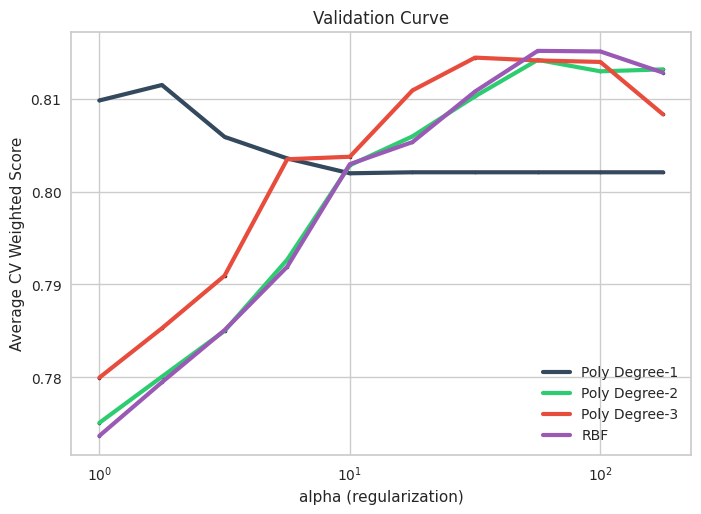

In [137]:
#| echo: false
import dill

model = dill.load(open(fdir_model+'SVC.dill','rb'))
df_model = pd.DataFrame(model.cv_results_)

df_rbf = df_model[(df_model['param_SVC__kernel']!='poly') & (df_model['param_SVC__kernel']!='rbf')]
x = df_rbf['param_SVC__C']
y = df_rbf['mean_test_score']
plt.plot(x, y, lw=3, label='Poly Degree-1')
plt.scatter(x, y, s=5, c = 'k')

df_svc = df_model[(df_model['param_SVC__degree']==2) & (df_model['param_SVC__kernel']=='poly')]
x = df_svc['param_SVC__C']
y = df_svc['mean_test_score']
plt.plot(x, y, lw=3, label='Poly Degree-2')
plt.scatter(x, y, s=5, c = 'k')

df_svc = df_model[(df_model['param_SVC__degree']==3) & (df_model['param_SVC__kernel']=='poly')]
x = df_svc['param_SVC__C']
y = df_svc['mean_test_score']
plt.plot(x, y, lw=3, label='Poly Degree-3')
plt.scatter(x, y, s=5, c = 'k')

df_rbf = df_model[df_model['param_SVC__kernel']=='rbf']
x = df_rbf['param_SVC__C']
y = df_rbf['mean_test_score']
plt.plot(x, y, lw=3, label='RBF')
plt.scatter(x, y, s=5)


plt.xscale('log')
plt.title('Validation Curve')
plt.xlabel('alpha (regularization)')
plt.ylabel('Average CV Weighted Score')
plt.legend()
plt.show()

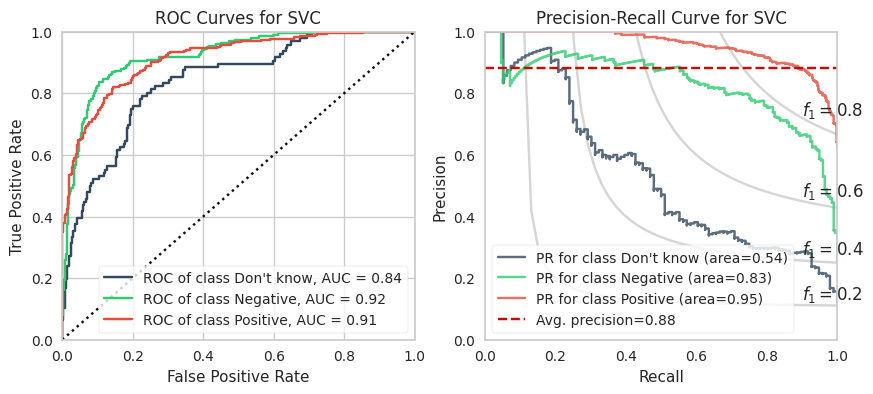

In [138]:
#| echo: false
#| error: false
#| warning: false
modelName = "SVC"
fname = fdir_model + f'{modelName}.dill'
plot_roc_pr(fname)

## E. Random Forest

There are many parameters in a decision tree and many more when aggregating over a forest of decision trees. Here are all of the relevant parameters we can change ([source](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)):

Note: Grid search was not extensive due to speed! Skipped to LGBM and XGBoost.

In [65]:
#| echo: false
param_name = ['n_estimators','max_depth', 'min_samples_split','min_samples_leaf', 'max_features', 'bootstrap',  'n_jobs', 'criterion' ]
value = [
    'The number of trees in the forest.', 
    'The maximum depth of tree from the root.', 
    'Minimum number of samples required for a split to be considered.',
    'Minimum number of samples required for each leaf.', 
    'The number of features to consider when choosing a split for an internal node.',
    'Whether bootstrap samples are used when building trees.', 
    'The number of jobs to run in parallel for both fit and predict. If -1, then the number of jobs is set to the number of cores.'
    'Criterion for splitting quality: Gini, Entropy, or Log Loss'
]
Markdown(tabulate(
  list(zip(param_name, value)), 
  headers=["Parameter", "Value"]
), )

Parameter          Value
-----------------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
n_estimators       The number of trees in the forest.
max_depth          The maximum depth of tree from the root.
min_samples_split  Minimum number of samples required for a split to be considered.
min_samples_leaf   Minimum number of samples required for each leaf.
max_features       The number of features to consider when choosing a split for an internal node.
bootstrap          Whether bootstrap samples are used when building trees.
oob_score          Whether to use out-of-bag samples to estimate the generalization accuracy.
n_jobs             The number of jobs to run in parallel for both fit and predict. If -1, then the number of jobs is set to the number of cores.Criterion for splitting quality: Gini, Entropy, or Log Loss

In [140]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

modelName = "RFC"
pipe = Pipeline([
    (modelName, RandomForestClassifier(class_weight='balanced',random_state=42)), 
])

param_grid = {
    'n_estimators': [1000], 
    'max_depth': [2, 4, 6, 8], 
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'criterion': ['gini', 'log_loss'],
}
param_grid = {f"{modelName}__{k}": param_grid[k] for k in param_grid.keys()}

model = GridSearchCV(pipe, 
                     param_grid = param_grid,
                     cv = 5,
                     n_jobs=8,
                     scoring = sentimentScorer,
                     )

model.fit(X_train, y_train) 

print("The best hyperparameters: ")
for k,v in model.best_params_.items():
    print(f"{k}: {v}")

fname = fdir_model + f'{modelName}.dill'
dill.dump(model, open(fname, 'wb'))

The best hyperparameters: 
RFC__criterion: gini
RFC__max_depth: 6
RFC__min_samples_leaf: 1
RFC__min_samples_split: 2
RFC__n_estimators: 1000


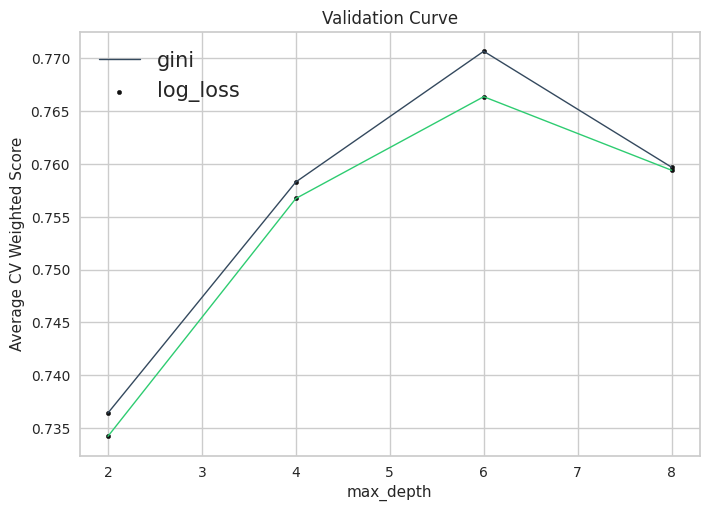

In [141]:
#| echo: false
import dill

model = dill.load(open(fdir_model+'RFC.dill','rb'))
df_model = pd.DataFrame(model.cv_results_)
df_gini = df_model[df_model['param_RFC__criterion']=='gini']
x = df_gini['params'].apply(lambda x: x['RFC__max_depth'])
y = df_gini['mean_test_score']
plt.plot(x, y, lw=1, label='gini')
plt.scatter(x, y, s=10, c = 'k')

df_log_loss = df_model[df_model['param_RFC__criterion']=='log_loss']
x = df_log_loss['params'].apply(lambda x: x['RFC__max_depth'])
y = df_log_loss['mean_test_score']
plt.plot(x, y, lw=1)
plt.scatter(x, y, s=10, c = 'k', label='log_loss')
plt.title('Validation Curve')
plt.xlabel('max_depth')
plt.ylabel('Average CV Weighted Score')
plt.legend(prop = { "size": 15 })
plt.show()

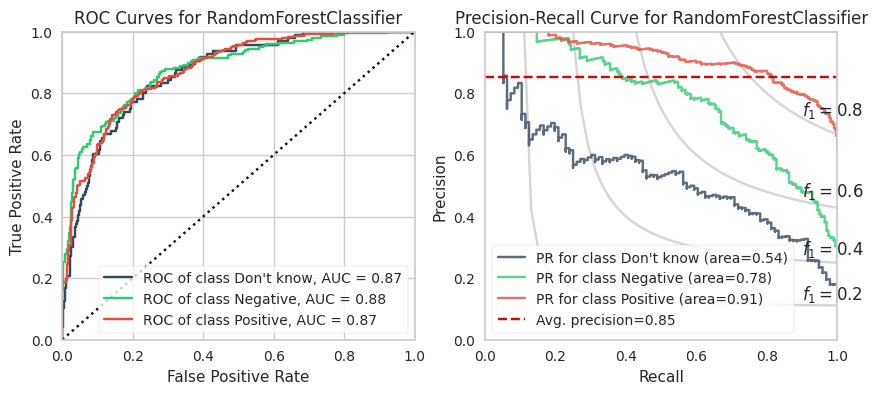

In [142]:
#| echo: false
#| error: false
#| warning: false
modelName = "RFC"
fname = fdir_model + f'{modelName}.dill'
plot_roc_pr(fname)

## F. XGBoost

In [146]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

modelName = "XGBC"
pipe = Pipeline([
    (modelName, XGBClassifier(tree_method='gpu_hist', random_state=42)), 
])

param_grid = {
    'eta': [1e-2],
    'n_estimators': [1000], 
    'max_depth': [2,4,6], 
    'min_child_weight': [1],
    'subsample': [0.5, 0.8],
    'colsample_bytree': [0.5, 0.8, 1]
}
param_grid = {f"{modelName}__{k}": param_grid[k] for k in param_grid.keys()}

model = GridSearchCV(pipe, 
                     param_grid = param_grid,
                     cv = 5,
                     n_jobs=2,
                     scoring = sentimentScorer,
                     )

kwargs_fit = {modelName+'__sample_weight':sample_weight_train}
model.fit(X_train, y_train, **kwargs_fit) 

print("The best hyperparameters: ")
for k,v in model.best_params_.items():
    print(f"{k}: {v}")

# CV does not set this by default... Needed for yellowbricks.
model.best_estimator_.steps[0][1].set_params(**{'num_class': len(LE.classes_)})

fname = fdir_model + f'{modelName}.dill'
dill.dump(model, open(fname, 'wb'))

The best hyperparameters: 
XGBC__colsample_bytree: 0.8
XGBC__eta: 0.01
XGBC__max_depth: 4
XGBC__min_child_weight: 1
XGBC__n_estimators: 1000
XGBC__subsample: 0.8


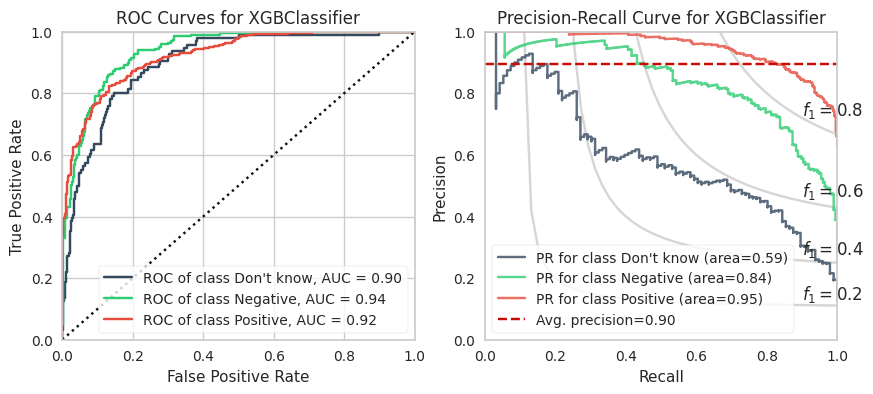

In [147]:
#| echo: false
#| error: false
#| warning: false
modelName = "XGBC"
fname = fdir_model + f'{modelName}.dill'
plot_roc_pr(fname)

## G. LightGBM

In [148]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

modelName = "LGBM"
pipe = Pipeline([
    (modelName, LGBMClassifier(class_weight="balanced", random_state= 42,  device='gpu', verbose=-1)), 
])

param_grid = {
    'learning_rate': [1e-2], 
    'max_depth': [2, 4, 6], 
    'subsample': [0.5, 0.8],
    'n_estimators': [1000],
    'reg_lambda': [1],
    'colsample_bytree': [0.5, 0.8, 1]
}

param_grid = {f"{modelName}__{k}": param_grid[k] for k in param_grid.keys()}

model = GridSearchCV(pipe, 
                     param_grid = param_grid,
                     cv = 5,
                     n_jobs=4,
                     scoring = sentimentScorer,
                     )

model.fit(X_train, y_train) 
print("The best hyperparameters: ")
for k,v in model.best_params_.items():
    print(f"{k}: {v}")

fname = fdir_model + 'LGBM.dill'
dill.dump(model, open(fname, 'wb'))

The best hyperparameters: 
LGBM__colsample_bytree: 0.5
LGBM__learning_rate: 0.01
LGBM__max_depth: 4
LGBM__n_estimators: 1000
LGBM__reg_lambda: 1
LGBM__subsample: 0.5


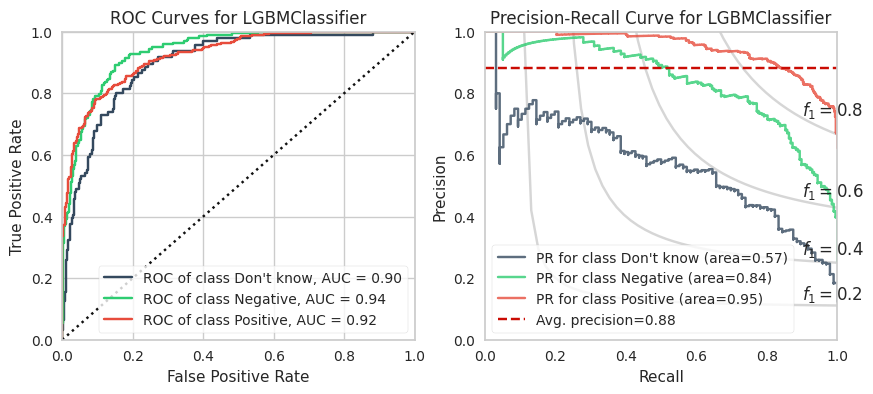

In [149]:
#| echo: false
#| error: false
#| warning: false
modelName = "LGBM"
fname = fdir_model + f'{modelName}.dill'
plot_roc_pr(fname)

In [ ]:
#| echo: false
#| freeze: true
from sklearn.metrics import precision_recall_curve
import dill
modelName = "XGBC_FINAL"
fname = fdir_model + f'{modelName}.dill'
model = dill.load(open(fname,'rb')).best_estimator_
y_pred_proba = model.predict_proba(X_test).transpose()

prt = []
for i in range(len(LE.classes_)):
    tmp = []
    out = precision_recall_curve(y_test, y_pred_proba[i], pos_label = i, drop_intermediate = True)
    tmp.append(out[0][:-1])
    tmp.append(out[1][:-1])
    tmp.append(out[2])
    tmp = np.array(tmp)
    
    prt.append(tmp)
    

cc = ys.colors.ColorMap('flatui').colors

for  i in range(len(LE.classes_)):
    color = cc[i]
    category = LE.inverse_transform([i])[0]
    plt.step(prt[i][-1],prt[i][0], color = color, label=f'{category} - Precision')
    plt.step(prt[i][-1],prt[i][1], lw=0.5, color = color, label=f'{category} - Recall')
    f1 = 2*prt[i][0]*prt[i][1]/(prt[i][0] + prt[i][1])
    plt.step(prt[i][-1],f1, alpha = 0.5, color = color, label=f'{category} - f1')

plt.axvline(0.44)

plt.xlabel('Probability Threshold')
plt.xlim(0,1)
plt.ylim(0,1)

plt.legend()